# The Peaklet Transform
Simple demonstrations of the Peaklet Transform. 

## A simple dataset

In [1]:
import numpy as np
import time

Nt = 1024 # number of elements in data array

<IPython.core.display.Javascript object>


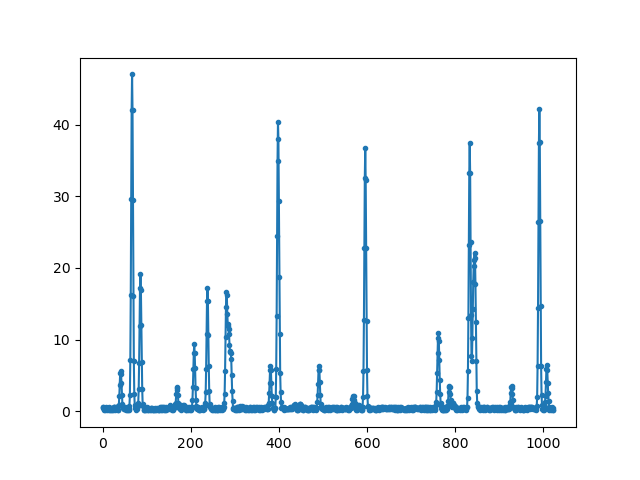

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

# fake data
signal1 = np.random.rand(Nt)**200
for i in range(8):
    signal1 += 0.5*(np.roll(signal1, 1) + np.roll(signal1, -1))
signal1 += 0.1 + 0.5*np.random.rand(Nt)  # add some noisy background.
plt.figure()
plt.plot(signal1,'.-');

In [3]:
# Timing test
import peaklets as peaklet

# Run with default peaklet function
start = time.perf_counter()
peaklet.pkxform(signal1)
end = time.perf_counter()
print("Compilation and execution: ",end-start,' s.')

start = time.perf_counter()
pk_default = peaklet.pkxform(signal1)
end = time.perf_counter()
print("Execution only: ",end-start,' s.')


# Run with specified peaklet function
pkfunk = peaklet.pk_trunc_para

start = time.perf_counter()
peaklet.pkxform(signal1, peaklet_func=pkfunk)
end = time.perf_counter()
print("Compilation and execution: ",end-start,' s.')

start = time.perf_counter()
pk_specified = peaklet.pkxform(signal1, peaklet_func=pkfunk)
end = time.perf_counter()
print("Execution only: ",end-start,' s.')


Compilation and execution:  7.341201916999999  s.
Execution only:  0.023804030000000864  s.
Compilation and execution:  4.210933775000001  s.
Execution only:  0.01940466099999938  s.


<IPython.core.display.Javascript object>


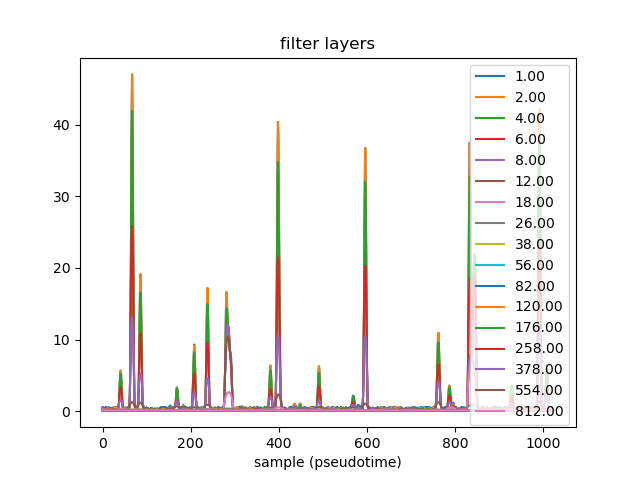

In [4]:
# Plot the filter layers for pk_specified.
pk = pk_specified  # select which transform to plot, pk_specified or pk_default.
Nsc = len(pk.scales)
plt.figure()
plt.title('filter layers')
for i in range(Nsc):
    labeltext = "{:.2f}"
    plt.plot(pk.filters[i,:],label=labeltext.format(pk.scales[i]))
plt.xlabel('sample (pseudotime)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


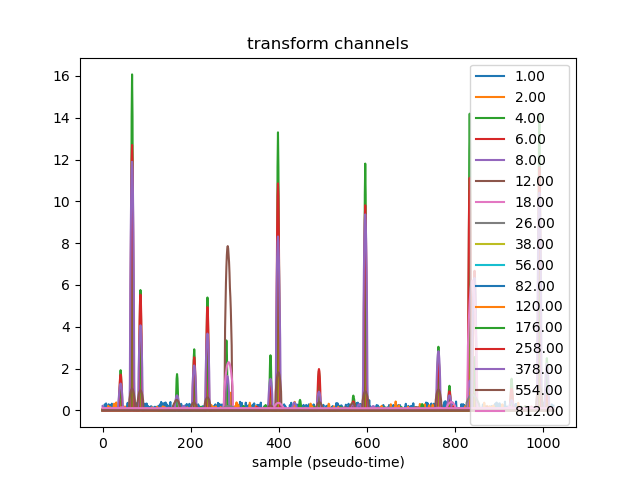

0.0


In [5]:
# plot the transform.
(Ntr,Nt) = pk.xform.shape
plt.figure()
plt.title('transform channels')
for i in range(Ntr):
    labeltext = "{:.2f}"
    plt.plot(pk.xform[i,:],label=labeltext.format(pk.scales[i]))
plt.xlabel('sample (pseudo-time)')
plt.legend()
plt.show()
print(np.amin(pk.xform))

In [6]:
def psplot(pkobj,dt=1.0,tunit='samples',punit='counts'):
    """
    Calculate and plot multiscale power spectrum.
    
    pkobj = PeakletXform object
    dt = sample period (default 1)
    tunit = unit of the time (sampling) axis (default 'samples')
    punit = unit of the light curve (default 'counts')
    """
    timescales = pkobj.scales*dt
    ps = np.sum(pkobj.xform,1)
    plt.semilogx(timescales, ps, '-o')
    plt.xlabel('scale ('+tunit+')')
    plt.ylabel('power ('+punit+')')
    return ps, timescales

<IPython.core.display.Javascript object>


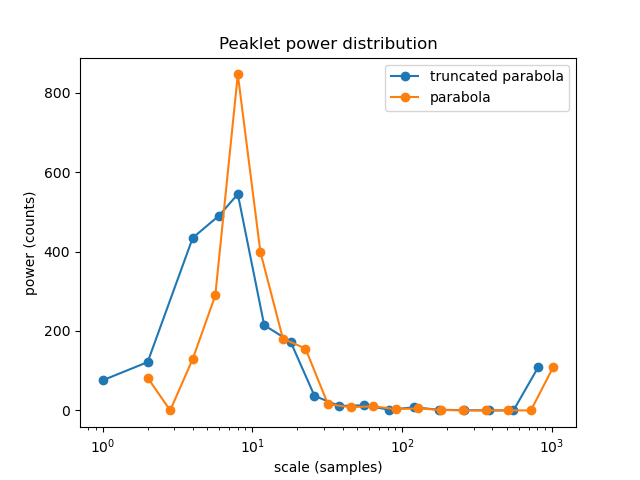

In [7]:
plt.figure()
ps_trunc_para,_ = psplot(pk_specified)
ps_default,_    = psplot(pk_default)
plt.legend(['truncated parabola','parabola'])
plt.title('Peaklet power distribution');

<IPython.core.display.Javascript object>


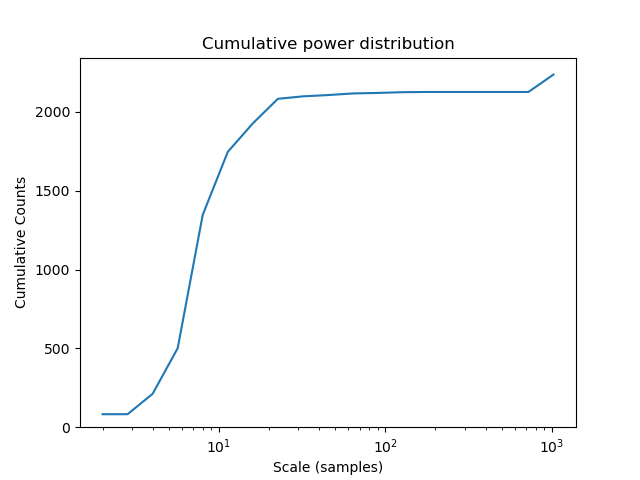

In [8]:
ps_cum = np.cumsum(ps_default)

plt.figure()
plt.semilogx(pk_default.scales,ps_cum)
plt.ylim(bottom=0)
plt.title('Cumulative power distribution')
plt.xlabel('Scale (samples)')
plt.ylabel('Cumulative Counts');

<IPython.core.display.Javascript object>


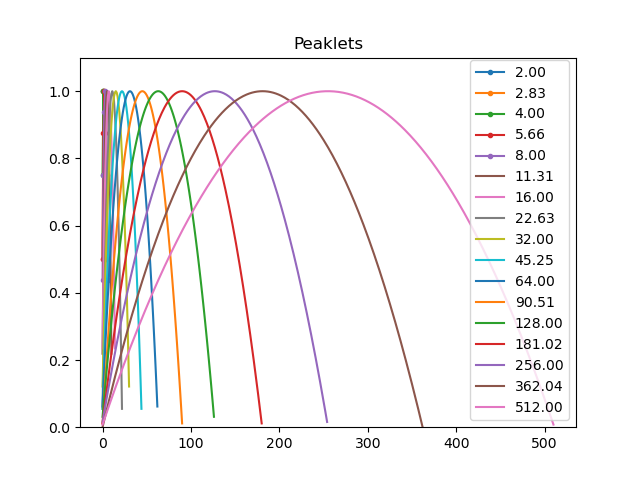

In [9]:
# Plot all the peaklets

plt.figure()
for i in range(Nsc):
    sc = pk_default.scales[i]
    if sc<10:
        marker='.-'
    else:
        marker='-'
    plt.plot(pk_default.pklets[i],marker,label=labeltext.format(sc))
plt.title('Peaklets');
plt.ylim((0,1.1))
plt.legend();

## Approximate Linearity
The peaklet transform, $\mathcal{P}$, is a mapping from nonnegative real time series $f(t)$ to a vector array of time series, $\mathbf{F}(t)$. I conjecture that $\mathcal{P}$, under certain assumptions, is _approximately linear_. I describe this property$^1$ as follows:

1. For any signal $f(t)$, and real constant $a \ge 0$,
$$
    \mathcal{P}(af) = a\mathcal{P}(f).
$$
1. If signals $f(t)$ and $g(t)$ are each composed of peaks with no mutual overlap in time, then
$$
    \mathcal{P}(f+g) = \mathcal{P}(f) + \mathcal{P}(g).
$$
1. If $f(t)$ and $g(t)$ are each composed of peaks with very different scales, then
$$
    \mathcal{P}(f+g) \approx \mathcal{P}(f) + \mathcal{P}(g).
$$



The following properties of $\mathcal{P}$ help to round out the picture.

4. There exists an inverse transform, $\mathcal{P}^{-1}$, with the property
$$ \mathcal{P}^{-1}\left( \mathcal{P}(f) \right) = f. $$
1. However, $\mathcal{P}$ is _not_ the inverse of $\mathcal{P}^{-1}$. That is, for some object $\tau$ in transform space, the following may or may not be an equality:
$$
    \mathcal{P} \left( \mathcal{P}^{-1}(\mathbf{T}) \right) \stackrel{?}{=} \mathbf{T}
$$
__Comment:__ Unless there exists an $f$ such that $\mathbf{T} = \mathcal{P}(f)$, the above relation is an inequality. _The transform space is much bigger than signal space_, and so $\mathcal{P}$ maps onto a proper subset, $\mathcal{F}$, of transform space. Most of the elements of transform space will never be generated using $\mathcal{P}$.
1. The inverse transform is linear. That is, given two signals $f(t)$ and $g(t)$,
$$
    \mathcal{P}^{-1}\left( \mathcal{P}(f) + \mathcal{P}(g)\right) = f + g.
$$
__Comment:__ In view of the previous rule, we cannot just hit both sides of the above equation with $\mathcal{P}$ to prove linearity! In this regard, please note that $\mathcal{F}$ is not closed under addition.


$^1$I thought about using the term [_quasilinear_, but this term is already taken.](https://www.cambridge.org/core/journals/bulletin-of-the-australian-mathematical-society/article/quasilinearity-of-some-composite-functionals-with-applications/31B0B0C9035DD3C652730F850A2A3A12) So are semi- and demilinear.

### Numerical tests of approximate linearity
Let's investigate quantitatively what the $\approx$ means in property (3) above. What I've been calling, e.g., $f(t)$, are really discretely sampled time series, which might be better denoted $f_t$, where $t$ is an integer time index. The transform space elements are rank two tensors, e.g.
$$
    f_t \stackrel{\mathcal{P}}{\longrightarrow} F_{ts}.
$$
Note that all elements of the time series $f_t$ and of the rank two tensor $F_{ts}$ are strictly _nonnegative_.
In addition to the time index, $F_{ts}$ is indexed by the scale, $s$, which is again dimensionless (like $t$, it has units of the sample time), but indicates a pulse width along the time axis. The inverse operator, $\mathcal{P}^{-1}$, is a very simple linear operation:
$$
    f_t = \mathcal{P}^{-1} F = \sum_s F_{ts}.
$$
Despite this, $\mathcal{P}$ is at best _approximately_ linear, and sometimes highly nonlinear. The linearity (nonlinearity) may be described as the degree of (in)accuracy in the following relation:
$$
    \mathcal{P}(f+g) \approx \mathcal{P}(f) + \mathcal{P}(g).
$$
I can measure the degree of inequality between two members of transform space, $F$ and $G$, using a normalized $L^1$ norm of their difference:
$$
    \Delta_{1N} (F,G) \equiv \frac{ \lVert F-G \rVert_1 }{\lVert F \rVert_1 + \lVert G \rVert_1} 
        = \frac{ \sum_{t,s} \left| F_{ts} - G_{ts} \right| }{ 
        \sum_{t,s} \left( F_{ts} + G_{ts} \right) }.
$$
I have taken advantage of the nonnegativity of both $F$ and $G$. Note that 
$$
    0 \le \Delta_{1N} (F,G) \le 1.
$$
If $\Delta_{1N} (F,G)=0$, then $F=G$. If $\Delta_{1N} (F,G)=1$, then there is no overlap between $F$ and $G$. That is, there is no $t,s$ such that both $F_{ts}$ and $G_{ts}$ are nonzero.

To quantify the degree of nonlinearity in $\mathcal{P}$ with respect to $F=\mathcal{P}(f)$ and $G=\mathcal{P}(g)$, we may simply use $\Delta_{1N} \left(F+G,\mathcal{P}(f+g) \right)=0$.



In [10]:
def Delta1N(F,G): 
    return np.sum(np.abs(F-G))/np.sum(F+G)

<IPython.core.display.Javascript object>


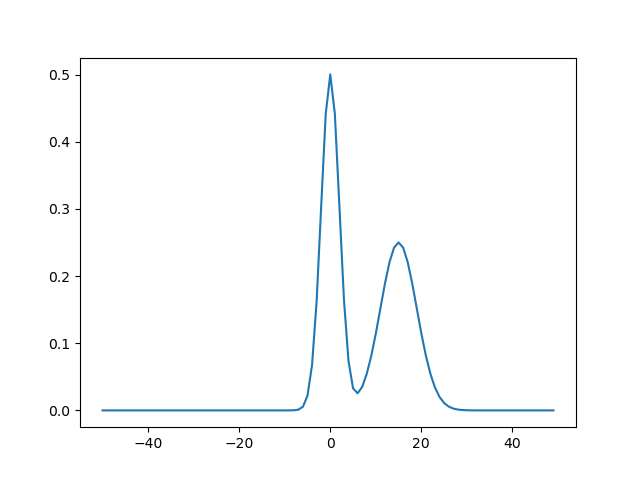

0.7527188737730731
5.013256549262001 5.013256549262001


In [11]:
Nt = 100
t = np.arange(Nt)-Nt/2.
wf = 2 # width of f
wg = 4 # width of g
f = (1/wf)*np.exp(-t**2/(2*wf**2))
shift = 2.5*(wf+wg)
g = (1/wg)*np.exp(-(t-shift)**2/(2*wg**2))
plt.figure()
plt.plot(t,f+g,'-')

fx = peaklet.pkxform(f)
gx = peaklet.pkxform(g)
fgx = peaklet.pkxform(f+g)

print(1-Delta1N(fgx.xform,gx.xform+fx.xform))
print(np.sum(fgx.xform), np.sum(gx.xform+fx.xform))

<IPython.core.display.Javascript object>


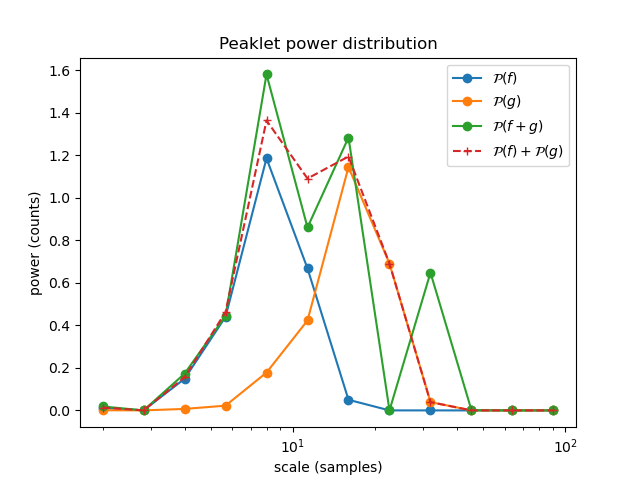

In [12]:
plt.figure()
ps = psplot(fx)
ps = psplot(gx)
ps = psplot(fgx)
plt.plot(fx.scales, np.sum(fx.xform+gx.xform,1),'+--')

plt.legend([r'$\mathcal{P}(f)$',r'$\mathcal{P}(g)$',r'$\mathcal{P}(f+g)$','$\mathcal{P}(f)+\mathcal{P}(g)$'])
plt.title('Peaklet power distribution');

In [13]:
######## LINEARITY CONTOUR PLOT ##########


Nt = 1000
t = np.arange(Nt) - Nt/2.
wf = 2**np.linspace(0,6,num=100) # width of f
wg =                            8 # width of g
nshift = np.linspace(-6, 6, num=100)

wfarr, nsarr, tarr = np.meshgrid(wf,nshift,t)

f = (1/wfarr)*np.exp( -tarr**2 / (2*wfarr**2) )

g = (1/wg)*np.exp( -(tarr - nsarr*(wfarr+wg))**2 / (2*wg**2) )


In [14]:
t_0 = time.perf_counter()
fx = peaklet.pkxform(f)
t_f = time.perf_counter()
print('transformed f array, ',f.shape, ', in ',t_f-t_0,'s.')
gx = peaklet.pkxform(g)
t_g = time.perf_counter()
print('transformed g array, ',g.shape, ', in ',t_g-t_f,'s.')
fgx = peaklet.pkxform(f+g)
t_fg = time.perf_counter()
print('transformed f+g array in ',t_fg-t_g,'s.')


transformed f array,  (100, 100, 1000) , in  202.411409376 s.
transformed g array,  (100, 100, 1000) , in  204.76072079399998 s.
transformed f+g array in  203.97441793400003 s.


In [15]:
print( fx.xform.shape )

(18, 100, 100, 1000)


## Messing around with an IRIS dataset.

In [16]:
import astropy.io
from astropy.io import fits
sji = fits.open('iris_l2_20130913_063651_4004255648_SJI_1400_t000.fits.gz')


In [17]:
print(dir(sji))

['__add__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_data', '_file', '_flush_resize', '_flush_update', '_in_read_next_hdu', '_open_kwargs', '_positive_index_of', '_read_all', '_read_next_hdu', '_readfrom', '_resize', '_truncate', '_try_while_unread_hdus', '_verify', '_wasresized', 'append', 'clear', 'close', 'copy', 'count', 'extend', 'fileinfo', 'filename', 'flush', 'fromfile', 'fromstring', 'index', 'index_of', 'info', 'insert', 'pop', 'readall', 'remove', 'reverse', 'run_option', 'sort',

In [18]:
sji.info()

Filename: iris_l2_20130913_063651_4004255648_SJI_1400_t000.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     163   (720, 771, 300)   int16 (rescales to float32)   
  1                1 ImageHDU        38   (31, 300)   float64   
  2                1 TableHDU        33   300R x 5C   [A10, A10, A3, A66, A55]   


In [19]:
# Extract SJI data cube
data = np.array(sji[0].data)
print(data.shape)

(300, 771, 720)


<IPython.core.display.Javascript object>


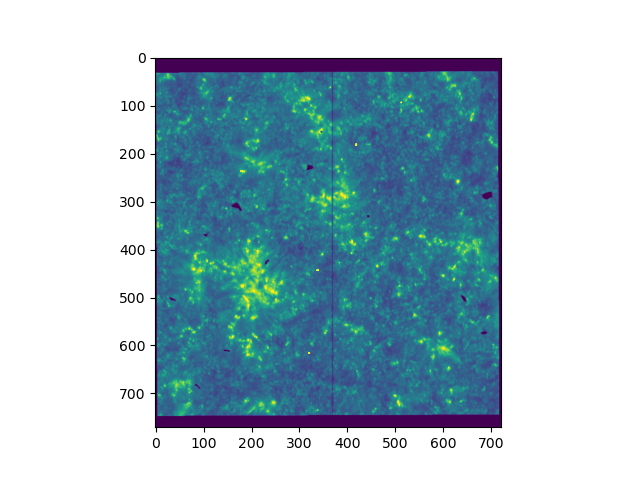

In [20]:
plt.figure()
#image = np.sqrt(np.maximum(data[0,:,:],0))
image = np.sqrt(np.maximum(np.percentile(data,95,axis=0),0))
plt.imshow(image, vmin=0, vmax=np.percentile(image,99.9))

<IPython.core.display.Javascript object>


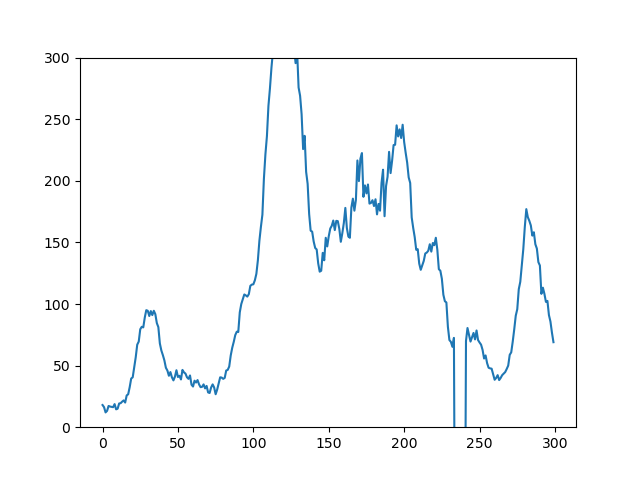

(0.0, 300.0)

In [21]:
plt.figure()
plt.plot(data[:,410,348])
plt.ylim((0,300))

[  17.75 -200.   -200.   -200.   -200.   -200.   -200.   -200.     15.25]


<IPython.core.display.Javascript object>


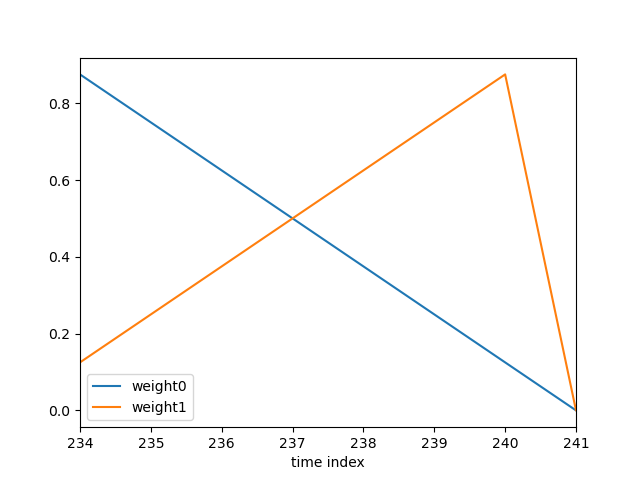

In [22]:
# Illustrate the data dropout
print(data[233:242,100,700])

# fix the data dropout
bad0 = 234  # starting index of dropout
bad1 = 241  # ending index of dropout
duration = bad1-bad0+1  # duration of dropout (number of exposures)
goodim0 = data[bad0-1,:,:] # last good image before dropout
goodim1 = data[bad1,:,:] # first good image after dropout
data2=data.copy()
weight0 = np.zeros((300))
weight1 = np.zeros((300))
for i in range(bad0,bad1):
    weight1[i] = (i-bad0+1)/(duration)
    weight0[i] = 1 - weight1[i]
    data2[i,:,:] = weight0[i]*goodim0 + weight1[i]*goodim1

plt.figure()
plt.plot(weight0,label='weight0')
plt.plot(weight1,label='weight1')
plt.xlabel('time index')
plt.xlim((bad0,bad1))
plt.legend();

<IPython.core.display.Javascript object>


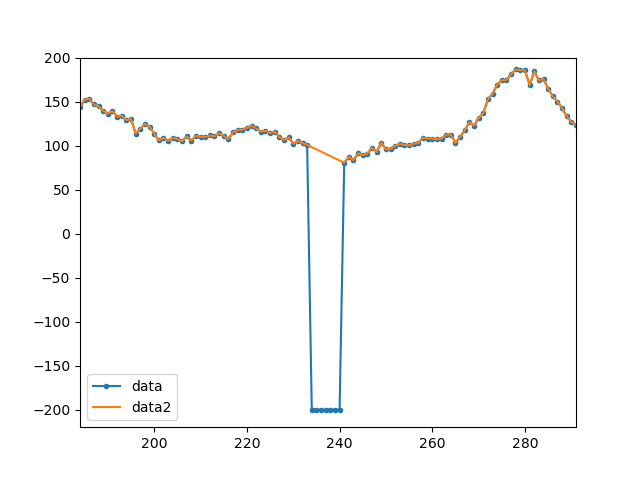

In [23]:
# Examine the interpolation at a particular spatial point.
plt.figure()
ytest=488
xtest=245
plt.plot(data[:,ytest,xtest],'.-',label='data')
plt.plot(data2[:,ytest,xtest],label='data2')
plt.xlim((bad0-50,bad1+50))
plt.ylim((-220,200))
plt.legend();

<IPython.core.display.Javascript object>


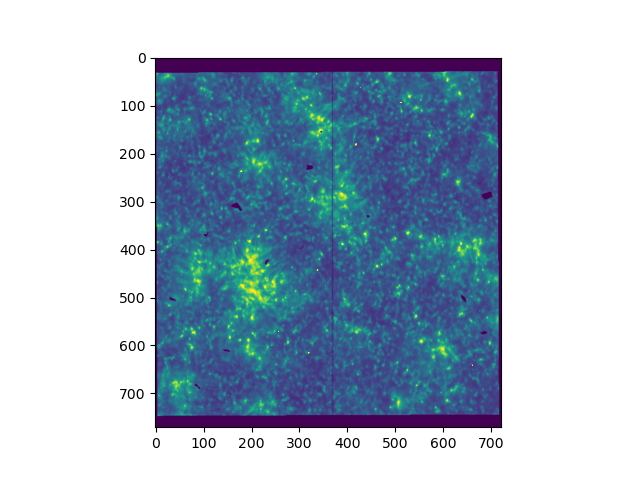

In [24]:
# Examine the middle interpolated image, to make sure it's not crazy.
plt.figure()
image = np.sqrt(np.maximum(data2[(bad0+bad1)//2,:,:],0))
plt.imshow(image, vmin=0, vmax=np.percentile(image,99.9));

In [25]:
dt = sji[0].header["CDELT3"]
exp_time = sji[0].header["EXPTIME"]
start_time = sji[0].header["DATE_OBS"]
print("SJI data cube beginning ",start_time)
print("Cadence = ",dt,' s.')
print("Exposure time = ",exp_time,' s.')

SJI data cube beginning  2013-09-13T06:36:51.620
Cadence =  3.80458  s.
Exposure time =  2.00042  s.


In [26]:
print(sji[0].header)

SIMPLE  =                    T / Written by IDL:  Sat May 20 07:04:35 2017      BITPIX  =                  -32 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                  720 /                                                NAXIS2  =                  771 /                                                NAXIS3  =                  300 /                                                EXTEND  =                    T / FITS data may contain extensions               DATE    = '2017-05-20'         / Creation UTC (CCCC-MM-DD) date of FITS header  COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    TELESCOP= 'IRIS    '           /                                                INSTRUME= 'SJI     '           /                                                DATA_LEV=              2.00000 /        

In [27]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8
